# F) Direct vs iterative solvers

- **<font color='green'>[RUN & OBSERVE]</font>** $\rightarrow$ the cell should be run directly without modification
- **<font color='orange'>[RUN & PLAY]</font>** $\rightarrow$ the cell can be run directly, but some parameters should be changed interactively
- **<font color='red'>[FILL & RUN]</font>**    $\rightarrow$ the cell should be filled before being run
- **<font color='magenta'>[FILL & PLAY]</font>** $\rightarrow$ the cell should be filled, and then some parameters should be changed interactively.


______________
## 1) Problem definition

We consider the **Poisson equation**, that models several physics, such as electrostatics, membrane problems, static heat transfer, 2D isotropic and magnet-free magnetostatics, *etc*.,  and reads:

$$ \text{div}~ (h ~ \underline{\text{grad}}~ a) = s, $$

on the following domain $\Omega$:

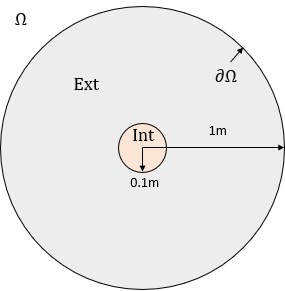

The physical state $a$ is supposed to be imposed to $0$ on the external boundary $\partial\Omega$, the transmission term $h=1$ is constant on the whole domain, and the local source term is $s=1$ inside `Int` and $s=0$ in `Ext`. The weak form of Poisson equation is its projection on a basis of test functions  $a^*\in\mathcal{H}^1(\Omega) = \{a:\Omega \rightarrow \mathbb{R},~ \text{such that}~ \int_\Omega a^2 + \lvert \underline{\text{grad}}~a\rvert^2 \leq \infty\}$. After integrating by parts, we get

$$\forall v \in \mathcal{H}^1(\Omega), \quad 
\displaystyle  -\int _{\Gamma }v \underline{\text{grad}}~ a \cdot \underline{n} + \int _\Omega \underline{\text{grad}}~ v \cdot (h~\underline{\text{grad}}~ a) =\int _{\Omega }a^*~s.$$

Since we consider homogeneous Dirichlet boundary conditions, we take the trial and test functions $a$ and $a^*$ in $\mathcal{H}^1_0(\Omega) = \{a\in \mathcal{H}^1, a=0 ~\text{on}~ \partial \Omega  \}$, so that the boundary integral vanishes :

$$\boxed{\forall v \in \mathcal{H}^1_0(\Omega), \quad 
\displaystyle  \underbrace{\int _\Omega \underline{\text{grad}}~ v\cdot (h~\underline{\text{grad}}~ a)}_{\text{Bilinear form}} = \underbrace{\int _{\Omega }v~s}_{\text{Linear form}}}.$$


________________

## 1) 2D analysis

To begin with, we want to solve the Poisson equation defined previously on a 2D domain. The first thing to do is to define the geometry, *i.e.* define the shape of the subdomains as well as their labels. In particular, we need to define the following labels :
- the inner disk : `Int`
- the outer domain : `Ext`
- the outer boundary : `dOmega`

The 2D geometry is created in the following cell.


|**<font color='green'>[RUN & OBSERVE]</font>**|
|---|

In [ ]:
#-------------------------------------------------------------
# 1) Creation of the Solids
from netgen.geom2d import CSG2d, Circle
Int = Circle( center=(0,0), radius=0.1, mat = "Int" )
Out = Circle( center=(0,0), radius=1, mat = "Ext", bc = "dOmega" )
Ext = Out - Int
# 2) Creation of the Geometry
Omega2D = CSG2d()
Omega2D.Add(Int)
Omega2D.Add(Ext)
#-------------------------------------------------------------
# 3) Mesh and plot
from ngsolve import Mesh
mesh2D = Mesh(Omega2D.GenerateMesh(maxh=0.01178))
print(f"Number of elements : {mesh2D.ne}, Number of nodes : {mesh2D.nv}")
from ngsolve.webgui import Draw
Draw(mesh2D)

Then, we have to define the weak form we want to solve. We therefore need to define the following mathematical objects:
   - the finite element space `fes2D`;
   - the bilinear form `K2D` (left-hand side integral of the weak form), that contains the test function `aStar` and the trial function `a` that we are looking for;
   - the linear form `s2D` (right-hand side of the weak form) that contains only the test function.

|**<font color='red'>[FILL & RUN]</font>**|
|---|

In [ ]:
from ngsolve import H1, grad, dx, BilinearForm, LinearForm

fes2D = .................
aStar = fes2D.TestFunction()
a = fes2D.TrialFunction()
K2D = BilinearForm( ................. )
s2D = LinearForm(................. )

Once defined the FES with the symbolic bilinear and linear forms, we can assemble and then solve the finite element system.

*By contrast to what seems to be written in the code below, the inverse of such a big the matrix should **never** be computed directly, because its sparsity is not garanteed, so the memory needed might be prohibitive. A dedicated solver should be used instead and does a much more efficient job.*

We use two different kind of solver :
- a **direct solver**, which decomposes the matrix to then solve the problem *exactly*. The decomposition step is computationnally expensive (O(N^3)), but can be reused to solve very efficiently the same problem for different right-hand sides. These solvers are almost *insensitive to the condition number* of the matrix, but performs better when it *bandwith is small*;
- an **iterative solver**, that compute a sequence of vectors that should converge to the solution; once the residual is smaller than a given tolerance, the computation stops and returns an approximate solution. These solver are *sensitive to the condition number of the matrix*, but are *insensitive to its bandwith*. Each iteration has a temporal complexity in $O(n_{nz})$

| Observe and comment the computation time for both solvers. What solver should be used for 2D problems ?|
|---|

|**<font color='green'>[RUN & OBSERVE]</font>**|
|---|


In [ ]:
from ngsolve.krylovspace import CGSolver
import time

###########################
# Assembly of the matrix and right-hand side (RHS)
K2D.Assemble() # Matrix
s2D.Assemble()   # RHS

###########################
# Direct solver
from ngsolve import GridFunction
solutionDirect = GridFunction(fes2D)
tic = time.time()
directSolver = K2D.mat.Inverse(freedofs=fes2D.FreeDofs(), inverse = "sparsecholesky") # default solver
solutionDirect.vec.data = directSolver * s2D.vec 
print(f"Time direct solver : {(time.time()-tic) * 1000  :.0f} ms")

###########################
# Iterative solver
solutionIterative = GridFunction(fes2D)
tic = time.time()
iterativeSolver = CGSolver(K2D.mat, freedofs=fes2D.FreeDofs(),  atol  = 1e-12,  maxiter  = 1000)
solutionIterative.vec.data = iterativeSolver * s2D.vec
print(f"Time iterative solver : {(time.time()-tic) * 1000  :.0f} ms")

print(f"\n Plot of the gradient of the solution (2D)")
Draw(grad(solutionDirect),mesh2D, vectors = { "grid_size":100})

Direct solver seems to perform better. Then we move to the 3D case.
________________

## 2) 3D analysis

Again, we define the geometry in 3D. We pay attention to using approximately the same number of nodes to obtain an FE system with the same number of degrees of freedom.


|**<font color='green'>[RUN & OBSERVE]</font>**|
|---|

In [ ]:
from netgen.csg import CSGeometry, Sphere, Pnt
#---------------------------------------------------------------
# Construction of the 3D geometry
Omega3D = CSGeometry()
Int = Sphere(Pnt(0,0,0),0.1).mat("Int")
Out = Sphere(Pnt(0,0,0),1).bc('dOmega')
Ext = Out - Int

Omega3D.Add(Int)
Omega3D.Add(Ext)

#---------------------------------------------------------------
# Meshing :
ngmesh3D = Omega3D.GenerateMesh(maxh=0.051)
mesh3D = Mesh(ngmesh3D)

print(f"Number of elements : {mesh3D.ne}, Number of nodes : {mesh3D.nv}")
Draw(mesh3D, clipping={"y":1, "z":0, "dist":0})

|Complete the following code cell to define the Finite Element Space, the weak form and assemble the 3D Poisson problem to get the matrix `K3D` and the RHS `s3D`.|
|---|

|**<font color='red'>[FILL & RUN]</font>**|
|---|

In [ ]:
#---------------------------------------------------------------
# FES
fes3D = ..........................

#---------------------------------------------------------------
# Integral equations

K3D = ..........................
s3D = ..........................

#---------------------------------------------------------------
# Assembly
K3D.Assemble()
s3D.Assemble()

|Observe and comment the computation time for both solvers. What solver should be used for 3D problems ?|
|---|


|**<font color='green'>[RUN & OBSERVE]</font>**|
|---|

In [ ]:
###########################
# Direct solver
solutionDirect = GridFunction(fes3D)
tic = time.time()
directSolver = K3D.mat.Inverse(freedofs=fes3D.FreeDofs(), inverse = "sparsecholesky")
solutionDirect.vec.data = directSolver * s3D.vec 
print(f"Time direct solver : {(time.time()-tic) * 1000 : .0f} ms")

###########################
# Iterative solver
solutionIterative = GridFunction(fes3D)
tic = time.time()
iterativeSolver = CGSolver(K3D.mat, freedofs=fes3D.FreeDofs(),  atol  = 1e-12,  maxiter  = 1000)
solutionIterative.vec.data = iterativeSolver * s3D.vec
print(f"Time iterative solver : {(time.time()-tic) * 1000 :.0f} ms")

print(f"\n Plot of the gradient of the solution (3D)")
Draw(grad(solutionIterative),mesh3D, vectors = { "grid_size":100},clipping={"y":1, "z":0, "dist":0})

This time, the iterative solver seems a lot better!


## 3) Comparison

The previous section has shown that iterative solver seems to perform better than direct ones for 3D problems; and the explanation is not the number of degrees of freedom that are the similar in the 2D test case.

The explanation lies in the *structure* of the matrix. The time complexity of the direct method, based on Gauss elimination, is $O(bN^2)$, with $b$ the bandwith of the matrix. The notion of bandwith is illustrated below.


|Explain the difference of bandwith for the 2D and 3D case.|
|---|


***Tips***
- The non-zero terms in the row $i$ of the FE matrix are related to the neighboring nodes of the node $i$.
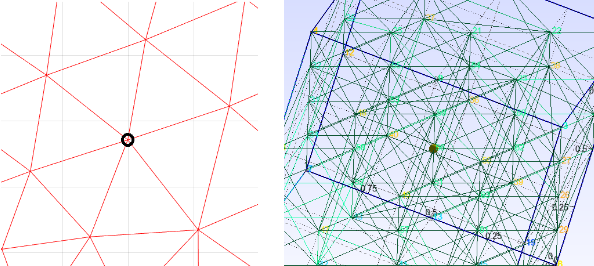


|**<font color='green'>[RUN & OBSERVE]</font>**|
|---|

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee
import  matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
ax1 = axs[0]
ax2 = axs[1]

#######################################
# Plot non-zeros terms of the reduced band 2D matrix
rows,cols,vals = K2D.mat.COO()
K2Dsp = csr_matrix((vals,(rows,cols)))
perm2D = reverse_cuthill_mckee(K2Dsp)
K1 = K2Dsp[perm2D,:];
ax1.spy(K1[:,perm2D],markersize = 1)
ax1.title.set_text('Reduced band FE matrix 2D')

#######################################
# Plot non-zeros terms of the reduced band 3D matrix
rows,cols,vals = K3D.mat.COO()
K3Dsp = csr_matrix((vals,(rows,cols)))
perm3D = reverse_cuthill_mckee(K3Dsp)
K1 = K3Dsp[perm3D,:];
ax2.spy(K1[:,perm3D],markersize = 1)
ax2.title.set_text('Reduced band FE matrix 3D')

plt.show()

## 4) Conclusion


The time complexity and the memory footprints depends on the bandwith of the matrix for the direct solvers (time complexity in $O(bN^2)$, with $b$ the bandwidth), while iterative solvers are unsensitive to the bandwith, so we concludes :
- **1D and 2D problems** $\Rightarrow$ low or medium connexity (average of 6 adjacent elements per node) $\Rightarrow$ **direct solvers**
- **3D problems** $\Rightarrow$  high connexity (up to 30 adjacent elements per node)  $\Rightarrow$  **iterative solvers**

However, iterative solvers are sensitive to the square root of the condition number of the matrix (often, preconditioning is needed).

References :

- https://www.irisa.fr/sage/jocelyne/cours/INSA/chapcreux2014.pdf
- http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf
- https://courses.engr.illinois.edu/cs357/su2014/lectures/lecture08.pdf
- https://perso.univ-rennes1.fr/eric.darrigrand-lacarrieu/Teaching/PdfFiles/PolyF04cours.pdf
- http://web.univ-ubs.fr/lmba/frenod/IMG/DocEtudiant/MTH1504/methodes-directes.pdf